# <center> Teoria y Ejemplos de la Semana 2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Teoría moderna de la cartera (MPT)
La **teoría moderna de la cartera (MPT)** es un marco matemático **para ensamblar una cartera de activos de modo que el rendimiento esperado se maximice para un nivel dado de volatilidad**. Es una formalización de la **diversificación en la inversión**, es decir, la idea de que poseer diferentes tipos de activos financieros es menos riesgoso que poseer un único activo.

## Fronteras Eficientes

En el MPT, la **frontera eficiente** es una curva que indica la parte **eficiente** del plano de **volatilidad-retorno**. Formalmente, es el conjunto de carteras que se pueden construir con los activos de entrada dados que tienen los rendimientos esperados máximos para un nivel fijo de volatilidad y, a su vez, las volatilidades más bajas para un nivel fijo de rendimiento esperado. La frontera eficiente fue formulada por primera vez por **Harry Markowitz** (1952).

Tenemos que construir una cartera de varios activos y **queremos encontrar los porcentajes óptimos de inversión que se asignarán a estos activos** para que, por ejemplo, el rendimiento total (esperado) de dicha cartera se maximice para un nivel dado de volatilidad.

Supongamos que tenemos $N > 1$ acciones y decidimos invertir nuestro capital en ellas. Sea $w:=(w_1, \ldots ,w_N)^T$, con $w_i \in (0,1)$ para todos $i =1, \ldots ,N$, donde cada
$w_i$ representa la proporción de la inversión (un porcentaje del capital invertido) en activos $i$. Estas cantidades $w_i$ son los pesos.

Dado que invertimos todo nuestro capital, existe $\sum_{i=1}^N w_i =1$ (esta es una estrategia de sólo largo plazo).

Sean $R_i$ y $R_p$ el rendimiento del activo $i$ y $p$ la rentabilidad total de la cartera, respectivamente. Del mismo modo, sea $\sigma_i$
 y $\sigma_p$ ​​la volatilidad del activo $i$ y $p$ la volatilidad de la cartera, respectivamente.

## Retorno de una cartera

El **rendimiento total de la cartera** será un promedio ponderado simple de los rendimientos (totales) de los activos individuales, es decir,
$$ R_p = \sum_{i=1}^N w_i R_i = w^T R,$$
 
dónde $R:=(R_1,\ldots ,R_N)^T$. Tenga en cuenta que si tenemos un conjunto de **datos de rendimientos anteriores**, el rendimiento total $R_p$ se calcula como arriba usando los retornos de los datos pasados. En cambio, si vamos a invertir ahora, no tenemos una serie de rentabilidades (pasadas) verdaderas, sino que tendríamos **rentabilidades esperadas**. Por tanto, en este caso tendríamos el valor maean
$E$ en la fórmula anterior.

## Volatilidad de una cartera

La **volatilidad de la cartera** se calcula como la (raíz cuadrada de) la varianza de la suma ponderada de los rendimientos de los activos individuales.

Consideremos un ejemplo con solo dos activos. Tenemos $w_1$ y $w_2$ y dos activos cuyos rendimientos son $R_1$ y $R_2$. Tenemos:

dónde 
$$ Cov(R_1,R_2):=E[(R_1 - \mu_1)(R_2 -\mu2)],$$
es la covarianza entre los dos activos y
 y
 denoten sus rendimientos medios, respectivamente. En particular, si dejamos
 
denotemos el coeficiente de correlación entre los activos, entonces la volatilidad de un
 cartera de activos se convierte en:
Tenga en cuenta que, utilizando la notación matricial, podemos escribir en forma compacta tal volatilidad. Eso es:
  
 
 
dónde
 es la matriz de covarianza cuadrada simétrica.

Ahora bien, en caso de $N$ acciones, sea de nuevo $\Sigma = [c_{ij}]$ la matriz de $N\times N$ de covarianza donde cada elemento $c_{ij}:=\sigma_i \sigma_j$, para
, denota la covarianza entre activos
 y activo
, y con
,
, y
 siendo las volatilidades y los coeficientes de correlación de los activos
 y
, respectivamente. por supuesto, cuando
,
 es simplemente la varianza del activo
 (estas son las entradas diagonales de la matriz de covarianza).

La volatilidad de la cartera viene dada entonces por:
$$ \sigma_p = \sqrt{W^TEw}$$

## Fronteras eficientes de carteras de 2 activos

A continuación, proponemos un ejemplo artificial para ver la curva que dibujan diferentes carteras que se construyen con sólo 2 activos con diferente correlación
$\rho_{12}$. En primer lugar, suponemos generar 500 devoluciones diarias de 2 activos:


In [5]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Luego, establecemos un valor para los medios y la volatilidad de nuestros dos activos artificiales:

In [6]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129


y nos instalamos 6 correlaciones de los dos activos, y para cada correlación fija, generaremos 20 carteras asignando 20 pares de pesos:

In [7]:
# La correlación va de 1 (completamente correlacionado) a -1 (inversamente correlacionado)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pares de ponderaciones que se utilizarán para construir las carteras para cualquier correlación dada
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

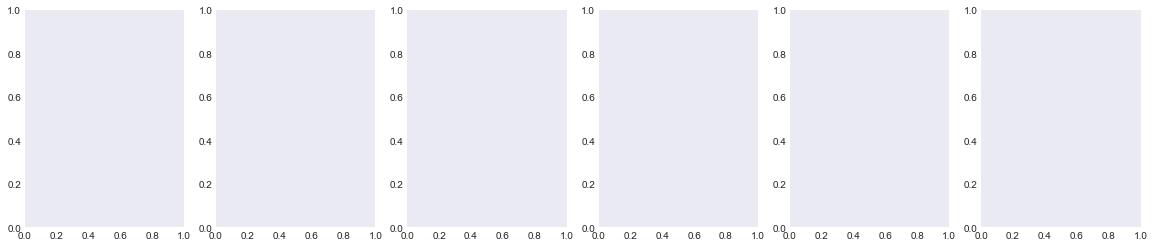

In [12]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(1,6, figsize=(20,4))    
ax = ax.flatten()
for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        


    



Para cualquier correlación dada, cada punto representa el par (rendimiento, volatilidad) de una cartera construida con alguna asignación porcentual. Esto se puede ver en la barra de colores: el **rojo corresponde a** $w = (0,1)$, es decir, asignación de dinero solo al primer activo, mientras que el **azul corresponde** a
$w=(0,1)$, es decir, asignación de dinero solo del segundo activo.

Podemos ver que **cuanto menor sea la correlación entre los activos, mejor será la compensación entre el rendimiento y la volatilidad:** en este ejemplo, cuando
$\rho = -1$, podríamos en principio construir una cartera que garantice alrededor de $30\%$
 de rentabilidad casi sin volatilidad.

## Ejemplo del mundo real: acciones de EE. UU.

Ahora obtendremos las series temporales de algunas acciones de la economía estadounidense y veremos cómo construir una cartera de manera eficiente.

In [15]:
tickers  = ['AMZN','KO','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2011,1,1), end=datetime(2019,1,1))["Adj Close"]   
    


TypeError: string indices must be integers